In [1]:
# import 구문 정렬
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.io.arff import loadarff
from scipy.io import arff
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, confusion_matrix
import tensorflow as tf
import seaborn as sns
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model, Sequential
from tensorflow.keras.activations import swish
from tensorflow.keras.layers import (LeakyReLU, Activation, Conv1D, MaxPooling1D, Flatten, Dense, 
                                     BatchNormalization, ReLU, GlobalAveragePooling1D, Dropout, 
                                     GlobalMaxPooling1D)
from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import xgboost as xgb
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier

# Plotting settings
plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['axes.unicode_minus'] = False  # minus 표시


In [2]:
# 드라이브에서 train, test 데이터셋 불러오기
# arff.loadarff() 함수는 두 개의 값 - 데이터 numpy array와 meta 데이터 객체를 반환
data_train, meta_train = arff.loadarff('./FordA/FordA_TRAIN.arff')
data_test, meta_test = arff.loadarff('./FordA/FordA_TEST.arff')

# 데이터를 DataFrame 형식으로 변환
train_df = pd.DataFrame(data_train)
test_df = pd.DataFrame(data_test)

In [3]:
# 데이터셋 훑어보기
train_df

,att1,att2,att3,att4,att5,att6,att7,att8,att9,att10,...,att492,att493,att494,att495,att496,att497,att498,att499,att500,target
0,-0.797172,-0.664392,-0.373015,0.040815,0.526936,0.984288,1.353120,1.578108,1.659251,1.640809,...,0.722417,0.362068,0.092083,-0.081268,-0.212573,-0.391456,-0.664392,-1.073796,-1.564343,b'-1'
1,0.804855,0.634629,0.373474,0.038343,-0.340988,-0.740860,-1.109667,-1.395357,-1.570192,-1.619951,...,0.049213,-0.258138,-0.510583,-0.683647,-0.773817,-0.785255,-0.714885,-0.560443,-0.319086,b'1'
2,0.727985,0.111284,-0.499124,-1.068629,-1.578351,-1.990534,-2.302031,-2.503403,-2.585211,-2.550600,...,0.463685,0.507735,0.517174,0.504588,0.476270,0.438513,0.394463,0.339400,0.255391,b'-1'
3,-0.234439,-0.502157,-0.732488,-0.946128,-1.139739,-1.323336,-1.490243,-1.607077,-1.620430,-1.506933,...,-0.929437,-0.922761,-0.929437,-0.909409,-0.835970,-0.695768,-0.478790,-0.188707,0.119736,b'-1'
4,-0.171328,-0.062285,0.235829,0.710396,1.239969,1.649823,1.876321,1.865535,1.703751,1.466467,...,0.725496,0.697453,0.731967,0.808545,0.839823,0.733046,0.437520,-0.026585,-0.602213,b'-1'
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3596,0.196022,-0.070102,-0.336226,-0.516799,-0.555282,-0.442793,-0.221369,0.025217,0.233320,0.350545,...,1.129082,0.528158,-0.039020,-0.573043,-1.061479,-1.514392,-1.934743,-2.316612,-2.603753,b'-1'
3597,0.041994,0.422255,0.740529,0.975426,1.109891,1.137270,1.058349,0.894955,0.671224,0.421544,...,-0.392667,-0.333749,-0.316543,-0.340299,-0.392876,-0.450805,-0.482609,-0.467769,-0.393755,b'1'
3598,-0.570054,-0.333165,-0.293519,-0.425344,-0.590869,-0.615648,-0.348033,0.275412,1.153586,2.035725,...,0.579700,0.157463,-0.353980,-0.885246,-1.314421,-1.512655,-1.393714,-0.942733,-0.270722,b'-1'
3599,2.006732,2.079150,2.022036,1.867560,1.648112,1.379446,1.093717,0.784057,0.434150,0.029284,...,1.148971,0.928088,0.634953,0.311682,-0.007376,-0.270543,-0.432145,-0.441231,-0.280709,b'1'


In [4]:
# train, test 데이터셋 정보 출력
print(train_df.info())
print(test_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3601 entries, 0 to 3600
Columns: 501 entries, att1 to target
dtypes: float64(500), object(1)
memory usage: 13.8+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1320 entries, 0 to 1319
Columns: 501 entries, att1 to target
dtypes: float64(500), object(1)
memory usage: 5.0+ MB
None


##### - train : 3601개 데이터, 501개 열 (target 1개 포함)
##### - test : 1320개 데이터, 501개 열 (target 1개 포함)
##### - 데이터 500개 열 값은 float64 type, 마지막 target열은 object type

In [5]:
# target 값은 [b'-1', b'1'] byte 형식으로 인코딩 되어 있음
print(train_df.target.unique())

# target 값을 일반 문자열로 디코딩 한 후, int 형으로 변환
train_df['target'] = train_df['target'].apply(lambda x: int(x.decode()))
test_df['target'] = test_df['target'].apply(lambda x: int(x.decode()))

# target 값 -1을 0으로 변환
train_df['target'] = train_df['target'].replace(-1, 0)
test_df['target'] = test_df['target'].replace(-1, 0)

print(train_df.target.unique()) # 변환 후 target 값 출력

[b'-1' b'1']
[0 1]


In [6]:
# 열 이름 변경 'att' -> 'sen' (센서 값)
train_df.columns = train_df.columns.str.replace('att', 's')
test_df.columns = test_df.columns.str.replace('att', 's')

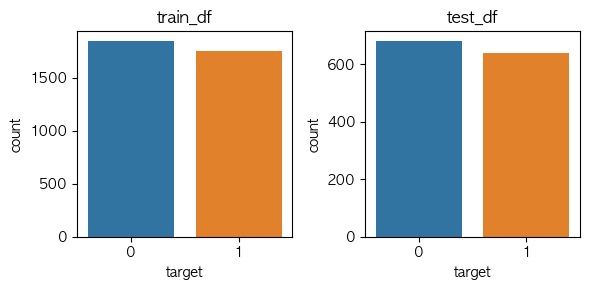

In [7]:
# 데이터셋의 target값 비중 불균형이 있는지 확인
#   -> sns.countplot: 범주형 데이터의 분포, sns.histplot: 연속형 데이터의 분포
fig, axs = plt.subplots(1,2, figsize=(6,3))
sns.countplot(data=train_df, x='target', ax=axs[0])
sns.countplot(data=test_df, x='target', ax=axs[1])
axs[0].set_title('train_df')
axs[1].set_title('test_df')
fig.tight_layout()
plt.show()

##### - 데이터셋의 target값 비중의 균형은 맞춰져 있다.

In [8]:
# 각 센서 값 살펴보기
train_df.describe()

,s1,s2,s3,s4,s5,s6,s7,s8,s9,s10,...,s492,s493,s494,s495,s496,s497,s498,s499,s500,target
count,3601.000000,3601.000000,3601.000000,3601.000000,3601.000000,3601.000000,3601.000000,3601.000000,3601.000000,3601.000000,...,3601.000000,3601.000000,3601.000000,3601.000000,3601.000000,3601.000000,3601.000000,3601.000000,3601.000000,3601.000000
mean,-0.016708,-0.015270,-0.013605,-0.011943,-0.009966,-0.007062,-0.003495,0.000568,0.005354,0.010032,...,0.006895,0.004053,0.000929,-0.001922,-0.003369,-0.003237,-0.001820,0.000031,0.001395,0.487365
std,1.058455,1.051904,1.044560,1.042573,1.046933,1.052829,1.055439,1.054305,1.050424,1.044120,...,1.040632,1.040826,1.036657,1.028358,1.018719,1.011871,1.012367,1.020914,1.032490,0.499910
min,-3.933454,-3.656912,-3.479467,-3.595350,-3.773891,-3.914729,-3.855301,-4.497360,-4.552591,-4.000282,...,-4.073011,-4.014450,-3.817036,-3.574256,-3.746353,-3.680805,-3.904569,-4.221550,-4.076032,0.000000
25%,-0.685693,-0.699526,-0.688302,-0.709732,-0.694991,-0.691035,-0.690316,-0.701244,-0.675094,-0.687749,...,-0.690143,-0.688232,-0.677701,-0.674282,-0.655946,-0.657258,-0.664392,-0.659578,-0.675838,0.000000
50%,-0.007573,-0.003044,-0.003066,0.008598,0.001042,0.000280,-0.011988,-0.026672,-0.002031,0.010602,...,0.012348,0.003914,0.005957,-0.002728,-0.010841,-0.008002,-0.004802,-0.013723,-0.003186,0.000000
75%,0.660360,0.674898,0.683698,0.679474,0.697530,0.688802,0.721442,0.705021,0.692256,0.689118,...,0.714817,0.707357,0.692837,0.666434,0.668463,0.671536,0.677346,0.684048,0.682921,1.000000
max,3.503936,3.369278,3.498286,3.493830,3.293318,3.605585,3.895870,3.741035,3.630933,3.579176,...,3.522197,3.842693,3.916653,3.670118,3.567879,3.471847,3.798079,3.863325,4.349744,1.000000


In [9]:
# 클래스가 0, 1인 인덱스 추출
idx_0 = train_df.loc[train_df.target==0].index
idx_1 = train_df.loc[train_df.target==1].index
print(len(idx_0))
print(len(idx_1))
len(idx_0)+len(idx_1)

1846
1755


3601

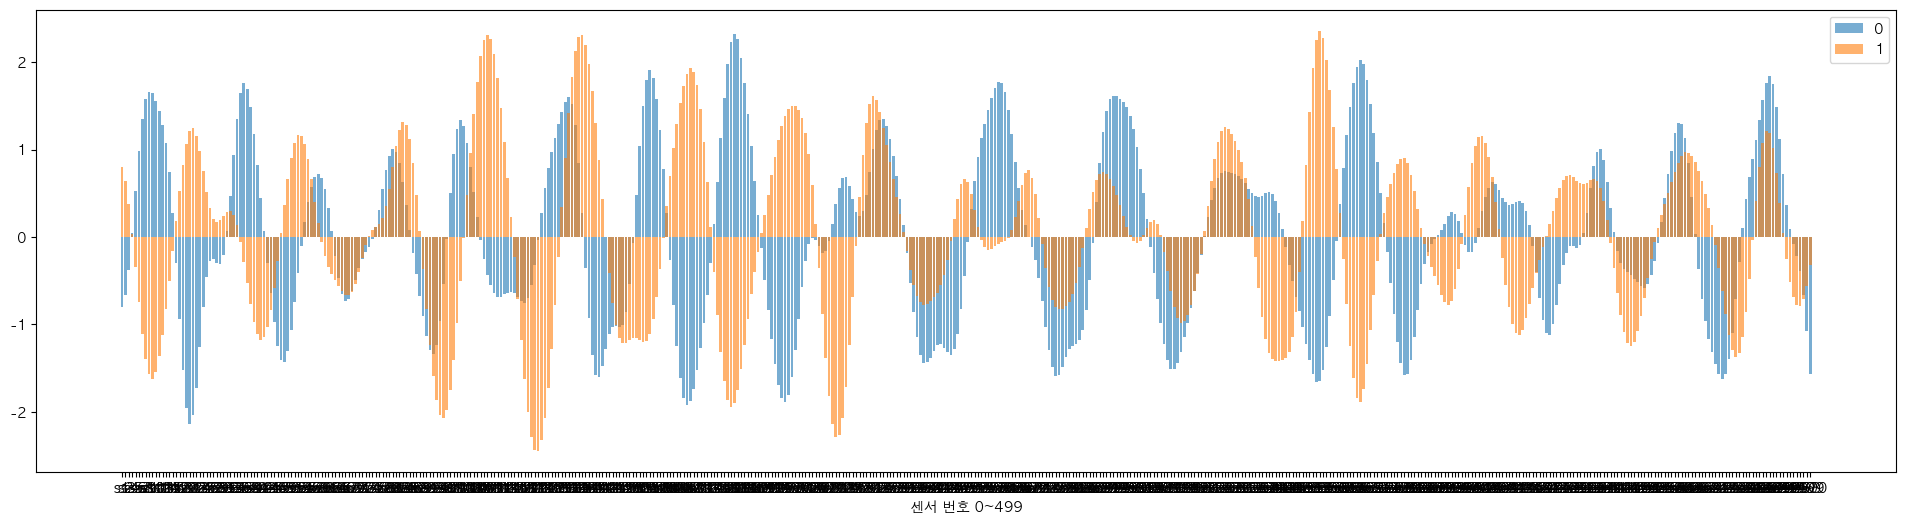

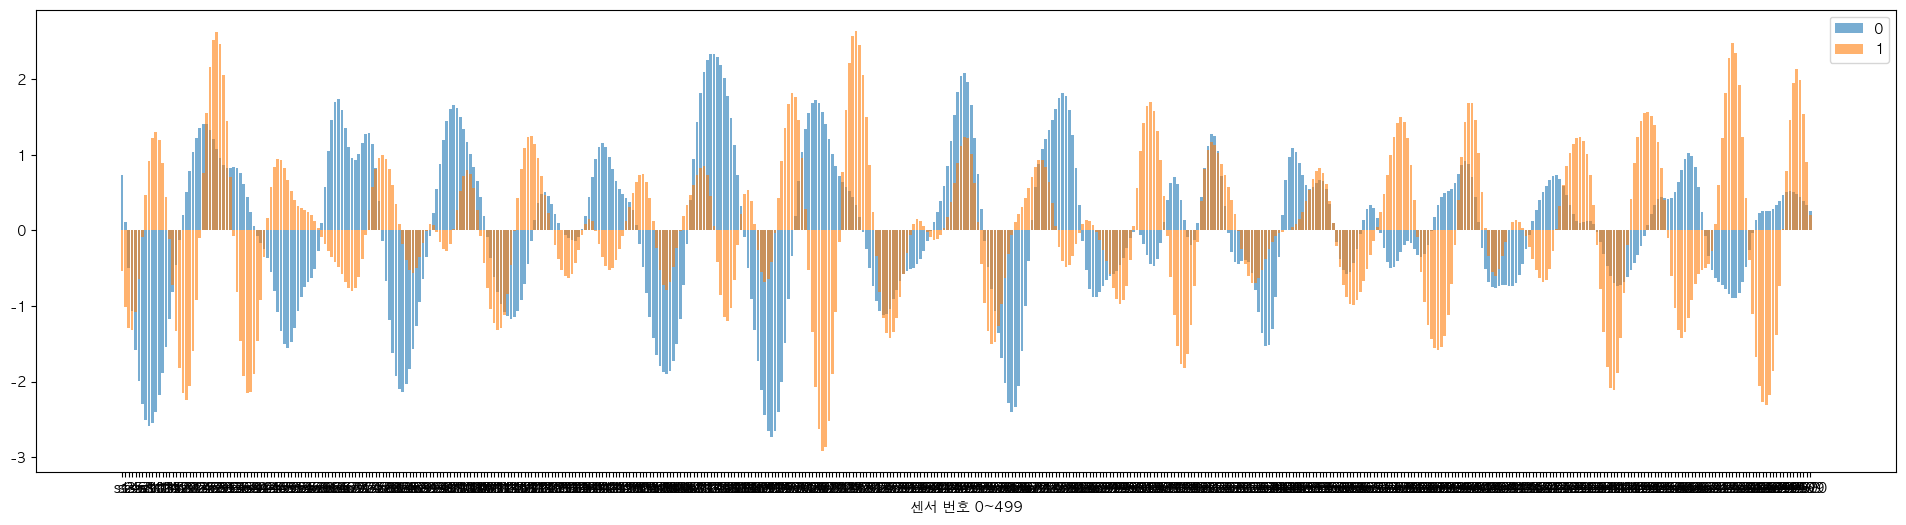

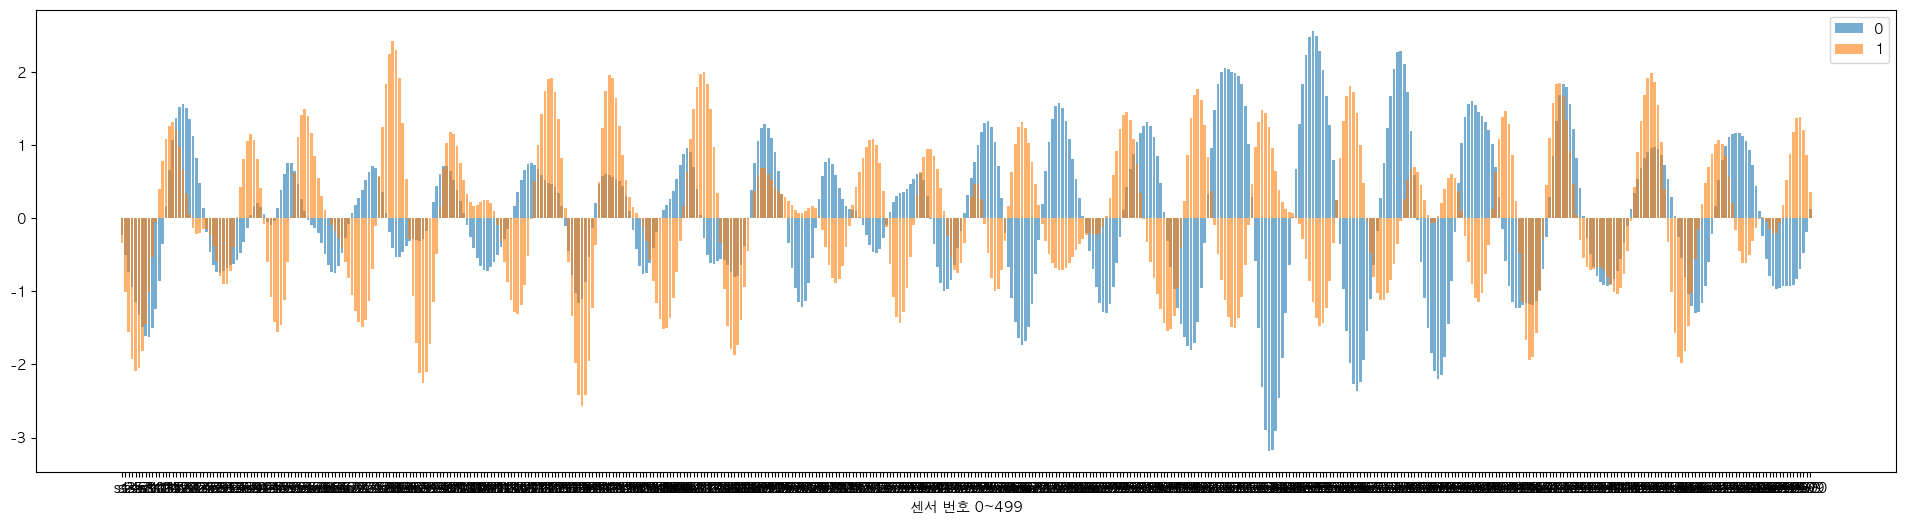

In [10]:
## 여러 샘플 비교해보기
# 가로:센서, 세로: 클래스별 1개 센서값(scatter)
for i in range(3): # 비교 하고 싶은 개수 설정
    plt.figure(figsize=(24,6))
    plt.bar(train_df.columns[:-1], train_df.iloc[idx_0[i], :-1], label='0', alpha=0.6)
    plt.bar(train_df.columns[:-1], train_df.iloc[idx_1[i], :-1], label='1', alpha=0.6)
    plt.xlabel('센서 번호 0~499')
    plt.legend()
    plt.show()

##### 낱개로 비교해서 보면 클래스별 차이가 있으나, 전체적으로 보면 경향이 안보임
##### -> 클래스별 전체 평균을 낼 필요 있음

In [11]:
# 각 센서의 그룹별(0,1) 평균 값
#   -> 센서별 평균값 barplot 데이터
s_means = train_df.groupby(by='target').mean()

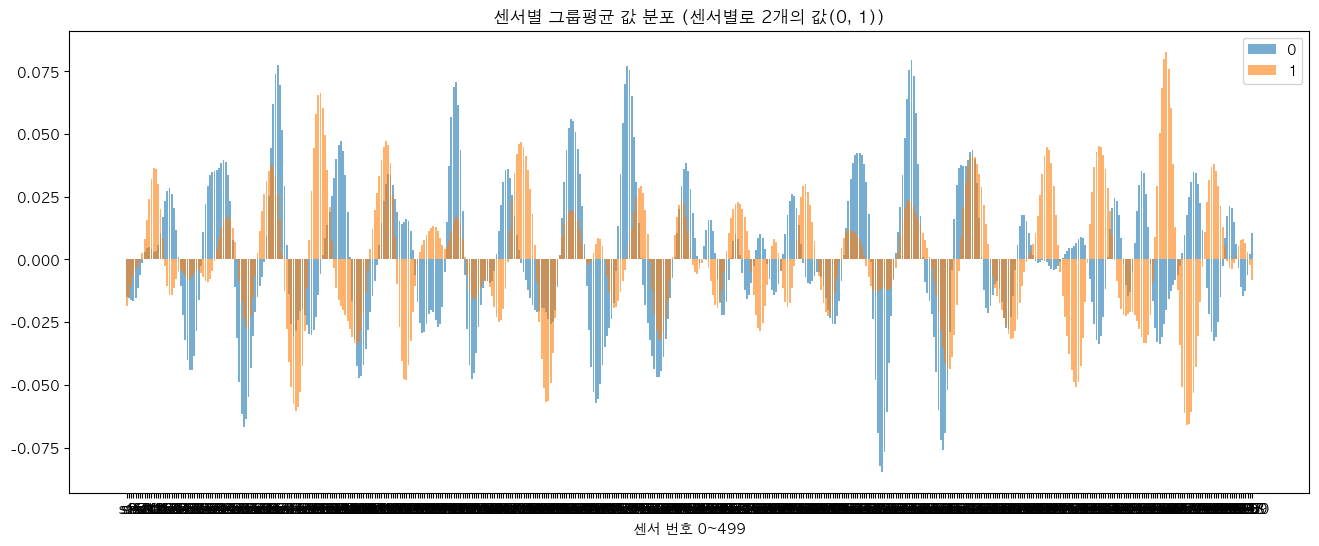

In [12]:
# 가로:센서, 세로:그룹별(0,1) 모든 제품들 센서값의 평균(scatter)
#   -> 센서별 그룹평균 값 분포 (센서별로 2개의 값(0, 1))
plt.figure(figsize=(16,6))
plt.bar(s_means.columns, s_means.iloc[0,:], alpha=0.6, label='0')
plt.bar(s_means.columns, s_means.iloc[1,:], alpha=0.6, label='1')
plt.title('센서별 그룹평균 값 분포 (센서별로 2개의 값(0, 1))')
plt.xlabel('센서 번호 0~499')
plt.legend()

plt.show()


##### - 센서별 평균 값이 -0.1 ~ 0.1 사이에 위치하고 있어 스케일링은 불필요 할것으로 보임
##### - 센서 후반부 클래스에 따라 센서값이 명확하게 갈림. -> 후반부 센서만 학습 시켜볼 필요 있음

In [13]:
# 각 행별로(제품별로) 센서값 min, max 리스트
idx_min, idx_max = [], []
for i in range(train_df.shape[0]):
    idx_min.append(train_df.iloc[i].min())
    idx_max.append(train_df.iloc[i].max())

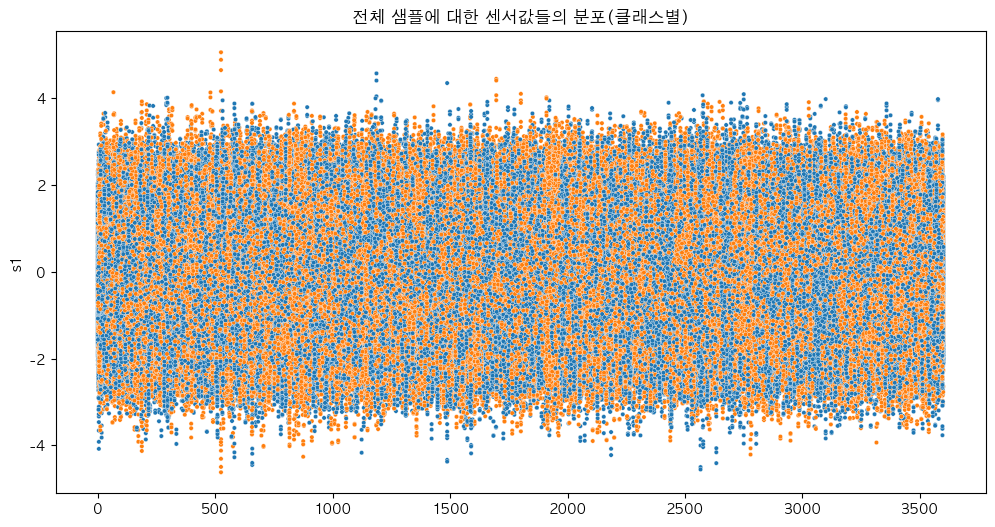

In [14]:
# 가로: 샘플, 세로: 모든센서들의 값(scatter) - 그룹별(0,1)
#   -> 전체 제품에 대한 센서값들의 분포(그룹별)
plt.figure(figsize=(12,6))
plt.title('전체 샘플에 대한 센서값들의 분포(클래스별)')
for i in range(train_df.shape[1]-1): #traget열 제외 모든 센서값 인덱싱
    sns.scatterplot(data=train_df, x=train_df.index, y=train_df.iloc[:,i], s=10, hue='target', legend=False)

# # 가로: 샘플, 세로: 모든센서들의 Min,Max(scatter) - 그룹별(0,1)
# #   -> 전체 제품에 대한 센서 Min,Max 범위(그룹별)
# plt.figure(figsize=(12,6))
# plt.title('전체 샘플에 대한 센서 Min, Max 범위(클래스별)')
# sns.scatterplot(data=train_df, x=train_df.index, y=idx_max, label='max', hue='target')
# sns.scatterplot(data=train_df, x=train_df.index, y=idx_min, label='min', hue='target')
# plt.legend()
# plt.show()

In [15]:
train_df.iloc[:, :-1]

,s1,s2,s3,s4,s5,s6,s7,s8,s9,s10,...,s491,s492,s493,s494,s495,s496,s497,s498,s499,s500
0,-0.797172,-0.664392,-0.373015,0.040815,0.526936,0.984288,1.353120,1.578108,1.659251,1.640809,...,1.120756,0.722417,0.362068,0.092083,-0.081268,-0.212573,-0.391456,-0.664392,-1.073796,-1.564343
1,0.804855,0.634629,0.373474,0.038343,-0.340988,-0.740860,-1.109667,-1.395357,-1.570192,-1.619951,...,0.386403,0.049213,-0.258138,-0.510583,-0.683647,-0.773817,-0.785255,-0.714885,-0.560443,-0.319086
2,0.727985,0.111284,-0.499124,-1.068629,-1.578351,-1.990534,-2.302031,-2.503403,-2.585211,-2.550600,...,0.394463,0.463685,0.507735,0.517174,0.504588,0.476270,0.438513,0.394463,0.339400,0.255391
3,-0.234439,-0.502157,-0.732488,-0.946128,-1.139739,-1.323336,-1.490243,-1.607077,-1.620430,-1.506933,...,-0.952804,-0.929437,-0.922761,-0.929437,-0.909409,-0.835970,-0.695768,-0.478790,-0.188707,0.119736
4,-0.171328,-0.062285,0.235829,0.710396,1.239969,1.649823,1.876321,1.865535,1.703751,1.466467,...,0.776188,0.725496,0.697453,0.731967,0.808545,0.839823,0.733046,0.437520,-0.026585,-0.602213
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3596,0.196022,-0.070102,-0.336226,-0.516799,-0.555282,-0.442793,-0.221369,0.025217,0.233320,0.350545,...,1.715205,1.129082,0.528158,-0.039020,-0.573043,-1.061479,-1.514392,-1.934743,-2.316612,-2.603753
3597,0.041994,0.422255,0.740529,0.975426,1.109891,1.137270,1.058349,0.894955,0.671224,0.421544,...,-0.463329,-0.392667,-0.333749,-0.316543,-0.340299,-0.392876,-0.450805,-0.482609,-0.467769,-0.393755
3598,-0.570054,-0.333165,-0.293519,-0.425344,-0.590869,-0.615648,-0.348033,0.275412,1.153586,2.035725,...,0.902821,0.579700,0.157463,-0.353980,-0.885246,-1.314421,-1.512655,-1.393714,-0.942733,-0.270722
3599,2.006732,2.079150,2.022036,1.867560,1.648112,1.379446,1.093717,0.784057,0.434150,0.029284,...,1.268671,1.148971,0.928088,0.634953,0.311682,-0.007376,-0.270543,-0.432145,-0.441231,-0.280709


# 시계열 데이터로 의미가 있는가? -> Timeseries plot with error bands
## -> 데이터가 너무 많아서 안될듯. 그냥 가오리로 끝내자

##### - 샘플 클래스별 센서값들의 분포는 차이가 없다. 

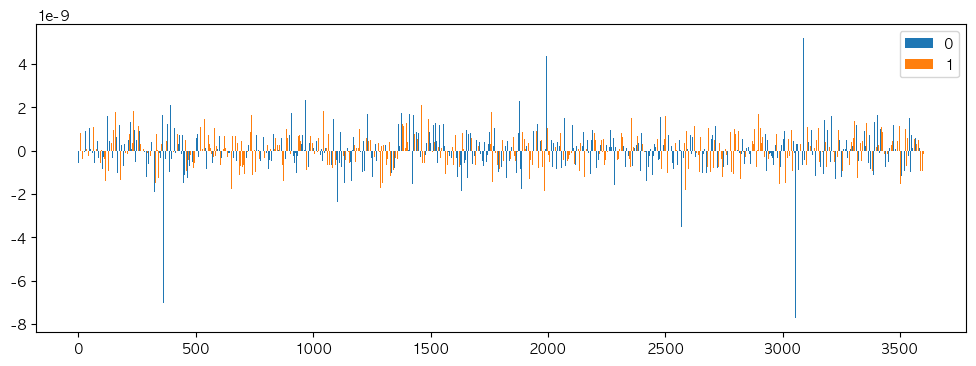

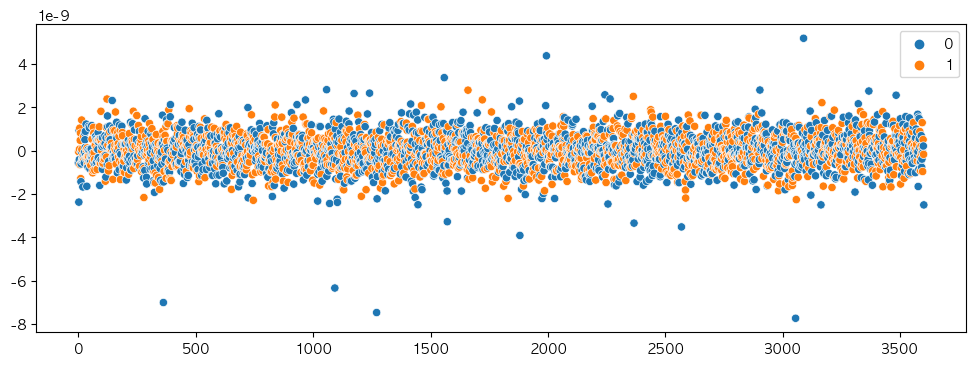

In [16]:
# 시계열로 분석할 가치가 있는지?
# 가로: 샘플, 세로: 전체 센서 값 평균(plot) - 그룹별(0,1)

# 아래 그래프를 sns.barplot을 이용해 hue인자를 쓰면 한줄로 된다. 근데 그래프가 뭉개진다. 확대하면 보임.
# 아래 그래프에서 돌출된게 5개 보이지만 실제로 다른것들도 있다. 전체 그래프에서는 안보이지만 확대하면 보임 (ex.1270행)

# 클래스별 데이터프레임 생성 -> 제품별(타임별) 평균값 시계열을 보기 위함
train_0 = train_df.loc[train_df.target == 0]
train_1 = train_df.loc[train_df.target == 1]

# 센서값 전체를 평균값 하나로 압축시켜서 시각화
plt.figure(figsize=(12,4))
plt.bar(train_0.index, train_0.iloc[:,:-1].mean(axis=1), label='0')
plt.bar(train_1.index, train_1.iloc[:,:-1].mean(axis=1), label='1')
plt.legend()

# 센서값 전체를 평균값 하나로 압축시켜서 시각화
plt.figure(figsize=(12,4))
sns.scatterplot(x=train_df.index, y=train_df.iloc[:,:-1].mean(axis=1), hue=train_df.target)
plt.legend()
plt.show()

##### - 0클래스에서 튀는값이 있다. ->  제거 전/후 학습 결과 비교 필요

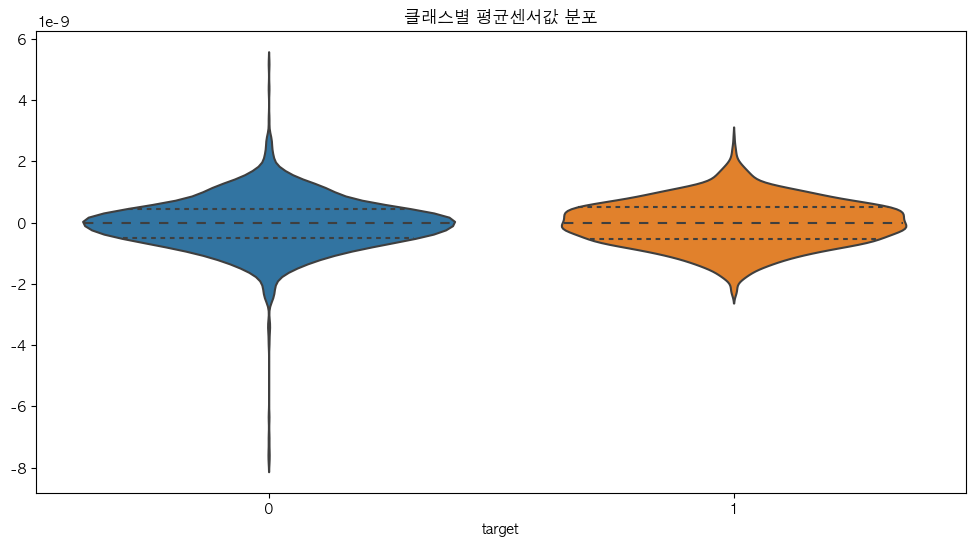

In [17]:
# 위 그래프를 violinplt 으로

plt.figure(figsize=(12,6))
sns.violinplot(x=train_df.target, y=train_df.iloc[:, :-1].mean(axis=1), inner="quart")

plt.title('클래스별 평균센서값 분포')
plt.xlabel('target')
plt.show()


In [18]:
# # 각 센서값을 abs처리 한뒤 평균값 하나로 압축
# # -> abs 처리하면 튀는 값 없어서 전처리 할게 없음. 차라리 삭제

# # plt.figure(figsize=(16,10))
# sns.scatterplot(data=train_df, x=train_df.index, y=train_df.iloc[:, :-1].abs().mean(axis=1), hue='target')

In [19]:
# # 주어진 코드를 stripplot으로 변경
# plt.figure(figsize=(12,6))
# sns.stripplot(data=train_df, x=train_df['target'], y=train_df.iloc[:, :-1].abs().mean(axis=1), jitter=True, marker='o', alpha=0.5)

# plt.title('전체 샘플에 대한 센서값들의 평균 분포(클래스별)')
# plt.xlabel('Target')
# plt.ylabel('Mean Sensor Value')
# plt.show()


In [20]:
# # 위 그래프를 violinplt 으로

# plt.figure(figsize=(12,6))
# sns.violinplot(x=train_df.target, y=train_df.iloc[:, :-1].abs().mean(axis=1), inner="quart")

# plt.title('클래스별 평균센서값 분포')
# plt.xlabel('target')
# plt.show()


##### - 시계열 데이터로 의미는 없어보인다. (RNN으로 학습 시켜볼 필요는 있음)

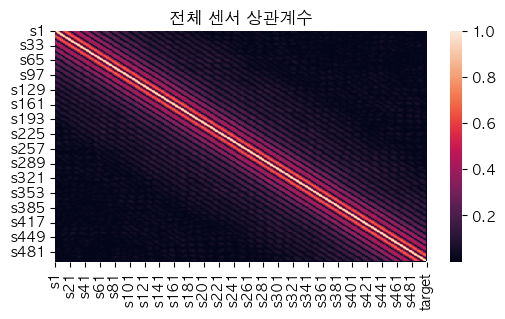

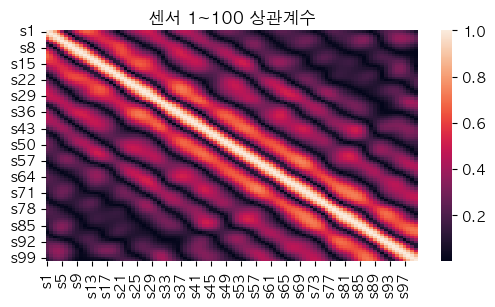

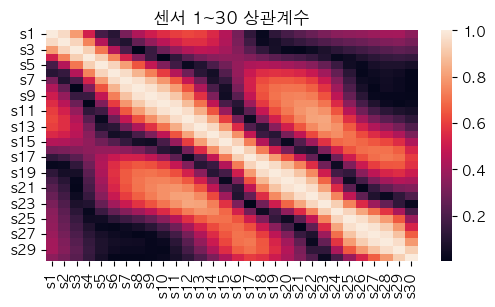

In [21]:
# target과 센서간의 상관관계 분석
# 전체 센서 상관계수
plt.figure(figsize=(6,3))
plt.title('전체 센서 상관계수')
train_corr = abs(train_df.corr())
sns.heatmap(train_corr)

# 센서 1~100 상관계수
plt.figure(figsize=(6,3))
plt.title('센서 1~100 상관계수')
corr_100 = abs(train_df.iloc[:100, :100].corr())
sns.heatmap(corr_100)

# 센서 1~30 상관계수
plt.figure(figsize=(6,3))
plt.title('센서 1~30 상관계수')
corr_30 = abs(train_df.iloc[:30, :30].corr())
sns.heatmap(corr_30, xticklabels=1)

fig.tight_layout()
plt.show()

##### - 인접한 3개 센서와 밀접한 연관성이 있다. (-> CNN)
#####   -> CNN 학습 특징 추출시 kernel_size를 3~4로 하면 효과적이다?

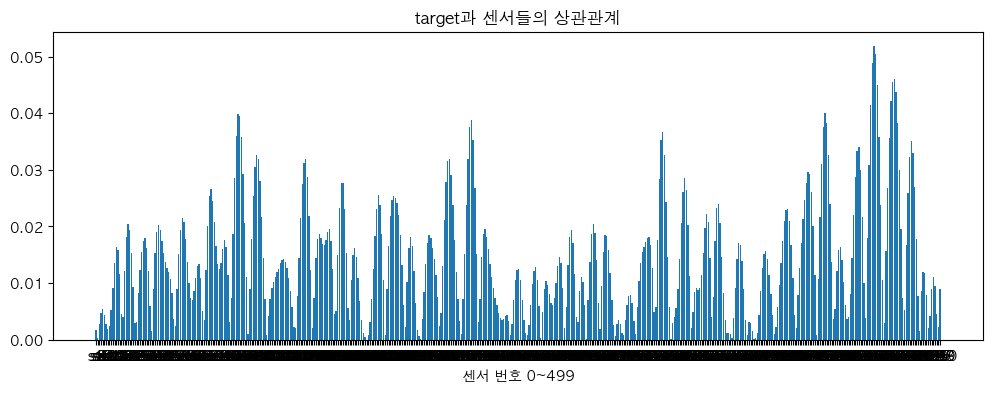

target과 상관관계 상위 센서
s461    0.051789
s462    0.050375
s460    0.048899
s473    0.045961
s472    0.045462
s463    0.044951
s474    0.043726
s471    0.042066
s459    0.041494
s432    0.040031
Name: target, dtype: float64


In [22]:
# 센서별 상관관계 값
#   -> 가로: 센서, 세로: target과 상관관계 값
plt.figure(figsize=(12,4))
plt.title('target과 센서들의 상관관계')
plt.xlabel('센서 번호 0~499')
plt.bar(train_df.columns[:-1], train_corr.target[:-1])

fig.tight_layout()
plt.show()

# target과 센서간의 상관계수를 내림차순 정리
#   -> target 값에 영향을 주는 센서가 몇번인지 확인
print('target과 상관관계 상위 센서')
print(train_corr.target.sort_values(ascending=False).head(11).drop('target',axis=0))

##### - 앞에서 본것 처럼 후반부가 상관관계가 높다. (s430 이후)
##### - 상관관계 상위 센서로만 학습해서 결과를 볼 필요 있음

In [23]:
# ML Best 모델 학습 중 과적합 추이
#   -> AutoGluon의 TabularPredictor 클래스를 사용하여 모델을 훈련하는 동안
#      세부적인 학습 과정 정보(val, val loss)를 직접 출력하는 것은 지원되지 않음
#       -> 모델을 따로 만들어서 출력 해야함

In [24]:
# 정규화 (정규화 안했을 때 정확도 더 높아서 취소)

# -----------------------------------------------------------------------
# # 정규화 안했을 떄
# <class 'xgboost.sklearn.XGBClassifier'>_acc : 77.05%
# <class 'lightgbm.sklearn.LGBMClassifier'>_acc : 78.56%
# <class 'catboost.core.CatBoostClassifier'>_acc : 84.55%
# <class 'sklearn.ensemble._forest.RandomForestClassifier'>_acc : 73.33%
# # 정규화 했을 떄
# <class 'xgboost.sklearn.XGBClassifier'>_acc : 76.89%
# <class 'lightgbm.sklearn.LGBMClassifier'>_acc : 77.8%
# <class 'catboost.core.CatBoostClassifier'>_acc : 83.86%
# <class 'sklearn.ensemble._forest.RandomForestClassifier'>_acc : 73.79%
# -----------------------------------------------------------------------

# from sklearn.preprocessing import StandardScaler
# stder = StandardScaler()
# stder.fit(x_train)
# x_train_t = stder.transform(x_train)

In [25]:
# train, test 데이터셋 라벨 분리 (x, y)
# AutoML에서는 라벨열을 지정해서 라벨을 인식했지만, 개별 ML에서는 라벨을 분리해서 학습
x_train = train_df.iloc[:, :-1]
y_train = train_df.iloc[:, -1]
x_test = test_df.iloc[:, :-1]
y_test = test_df.iloc[:, -1]

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(3601, 500)
(3601,)
(1320, 500)
(1320,)


In [26]:
# from catboost import CatBoostClassifier

# # 개별 ML 성능 시험 (테스트용 셀)

# t_model = CatBoostClassifier(verbose=0) # acc : 85.0%
# t_model.fit(x_train, y_train)
# y_pred = t_model.predict(x_test)
# accuracy = accuracy_score(y_test, y_pred)
# print(f'acc : {round(accuracy*100,2)}%')

In [27]:
train_df

,s1,s2,s3,s4,s5,s6,s7,s8,s9,s10,...,s492,s493,s494,s495,s496,s497,s498,s499,s500,target
0,-0.797172,-0.664392,-0.373015,0.040815,0.526936,0.984288,1.353120,1.578108,1.659251,1.640809,...,0.722417,0.362068,0.092083,-0.081268,-0.212573,-0.391456,-0.664392,-1.073796,-1.564343,0
1,0.804855,0.634629,0.373474,0.038343,-0.340988,-0.740860,-1.109667,-1.395357,-1.570192,-1.619951,...,0.049213,-0.258138,-0.510583,-0.683647,-0.773817,-0.785255,-0.714885,-0.560443,-0.319086,1
2,0.727985,0.111284,-0.499124,-1.068629,-1.578351,-1.990534,-2.302031,-2.503403,-2.585211,-2.550600,...,0.463685,0.507735,0.517174,0.504588,0.476270,0.438513,0.394463,0.339400,0.255391,0
3,-0.234439,-0.502157,-0.732488,-0.946128,-1.139739,-1.323336,-1.490243,-1.607077,-1.620430,-1.506933,...,-0.929437,-0.922761,-0.929437,-0.909409,-0.835970,-0.695768,-0.478790,-0.188707,0.119736,0
4,-0.171328,-0.062285,0.235829,0.710396,1.239969,1.649823,1.876321,1.865535,1.703751,1.466467,...,0.725496,0.697453,0.731967,0.808545,0.839823,0.733046,0.437520,-0.026585,-0.602213,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3596,0.196022,-0.070102,-0.336226,-0.516799,-0.555282,-0.442793,-0.221369,0.025217,0.233320,0.350545,...,1.129082,0.528158,-0.039020,-0.573043,-1.061479,-1.514392,-1.934743,-2.316612,-2.603753,0
3597,0.041994,0.422255,0.740529,0.975426,1.109891,1.137270,1.058349,0.894955,0.671224,0.421544,...,-0.392667,-0.333749,-0.316543,-0.340299,-0.392876,-0.450805,-0.482609,-0.467769,-0.393755,1
3598,-0.570054,-0.333165,-0.293519,-0.425344,-0.590869,-0.615648,-0.348033,0.275412,1.153586,2.035725,...,0.579700,0.157463,-0.353980,-0.885246,-1.314421,-1.512655,-1.393714,-0.942733,-0.270722,0
3599,2.006732,2.079150,2.022036,1.867560,1.648112,1.379446,1.093717,0.784057,0.434150,0.029284,...,1.148971,0.928088,0.634953,0.311682,-0.007376,-0.270543,-0.432145,-0.441231,-0.280709,1


In [28]:
# # ML 모델별로 학습하기
# from catboost import CatBoostClassifier

# model = [xgb.XGBClassifier(),
#         LGBMClassifier(),
#         CatBoostClassifier(verbose=0), #iteration=100:77.6%, 1000:84.55%, 1500:85.0%, 2000:84.62%
#         RandomForestClassifier()]

# # 모델명 리스트 (출력시 모델명 텍스트로 사용)
# model_list = []
# for i in range(len(model)):
#     model_list.append(type(model[i]).__name__)

# # 캔버스 3개 만들기 (혼동행렬 / Feat.Imp. 상위 10항목 / Feat.Imp. 전체 분포)
# fig, axs = plt.subplots(1, len(model), figsize=(3*len(model), 2))
# fig2, axs2 = plt.subplots(1, len(model), figsize=(3*len(model), 2))
# fig3, axs3 = plt.subplots(1, len(model), figsize=(3*len(model), 2))

# # 전체 모델 학습 후 정확도, 혼동행렬, Feat.Import. 출력하기
# for i in range(len(model)):
#     model[i].fit(x_train, y_train)
#     y_pred = model[i].predict(x_test)
#     accuracy = accuracy_score(y_test, y_pred)
#     print(f'{model_list[i]}_acc : {round(accuracy*100,2)}%')
    
#     # 혼동 행렬을 히트맵으로 그리기
#     conf_mat = confusion_matrix(y_test, y_pred) # 혼동 행렬 만들기 (2,2)
#     sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', ax=axs[i])
#     axs[i].set_title(model_list[i])
#     axs[i].set_ylabel('Actual')

#     # Feature importances 상위10 항목 구하기
#     imp_df = pd.DataFrame(model[i].feature_importances_) # ndarray 형태를 DataFrame 형태로 바꾸기
#     imp_df.rename(columns={0:'imp'}, inplace=True) # 열 이름 변경
#     imp_df.index = 's' + imp_df.index.astype(str) # 인덱스명 변경 ('s'추가하여 str으로)
#     imp_df_sort = imp_df.sort_values(by='imp', ascending=False) # 내림차순 정렬

#     axs2[i].bar(imp_df_sort.head(10).index, imp_df_sort.head(10).iloc[:, 0]) # top10 출력
#     axs2[i].set_title(model_list[i])
#     axs2[i].tick_params(axis='x', rotation=90)
#     axs2[i].set_xlabel('Sensor_no.')
#     axs2[i].set_ylabel('Importances')
    
#     # # Feature importances 전체 분포도
#     # sns.histplot(data=imp_df, x=imp_df.imp, ax=axs3[i])
#     # axs3[i].set_title(model_list[i])
#     # axs3[i].set_xlabel('Importances')
    
#     # Feature importances 센서별 분포
#     axs3[i].bar(imp_df.index, imp_df.imp.values)
#     axs3[i].set_title(model_list[i])
#     axs3[i].set_xlabel('Sensor_no.')
#     axs3[i].set_ylabel('Importances')
        
# fig.tight_layout()
# fig2.tight_layout()
# fig3.tight_layout()
# plt.show()

##### 후반부 센서의 Feature importances 값이 높게 나타나지 않음
##### -> target과 상관관계가 높은 센서라고 해서 Feature importances 값이 높은 것은 아니다.

##### CNN 하이퍼 파라미터 엑셀 참고

In [29]:
# # RNN(LSTM) 학습

# from tensorflow.keras.layers import LSTM

# def make_rnn_model():
#   model = Sequential()
#   model.add(LSTM(units=256, return_sequences=True,
#                  input_shape=(500, 1)
#                  ))
#   model.add(Flatten())
#   model.add(Dense(10, activation='relu'))
#   model.add(Dense(2, activation='softmax'))
#   return model

# rnn_model = make_rnn_model()

# rnn_model.compile(loss='sparse_categorical_crossentropy',
#                   optimizer='adam',
#                   metrics=['sparse_categorical_accuracy'])

# callbacks_rnn = [
#     ModelCheckpoint('rnn_best_model.h5', save_best_only=True,
#                     monitor='val_sparse_categorical_accuracy', mode='max'),
#     ]

# history_rnn = rnn_model.fit(x_train_exp, y_train,
#                             batch_size=64,
#                             validation_split=0.2,
#                             epochs=3,
#                             callbacks=callbacks_rnn,
#                             verbose=1)

# # Plotting the accuracy and validation accuracy
# plt.figure(figsize=(12, 12))
# plt.plot(history_rnn.history['sparse_categorical_accuracy'], label='Training accuracy')
# plt.plot(history_rnn.history['val_sparse_categorical_accuracy'], label='Validation accuracy')
# plt.plot(history_rnn.history['loss'], label='loss')
# plt.plot(history_rnn.history['val_loss'], label='val_loss')
# plt.ylabel('Accuracy')
# plt.xlabel('Epoch')
# plt.legend(loc='right')
# plt.show()

##### - 시계열 연관성 없음 

In [30]:
##################################
# 튀는값 제거 후 재학습
##################################

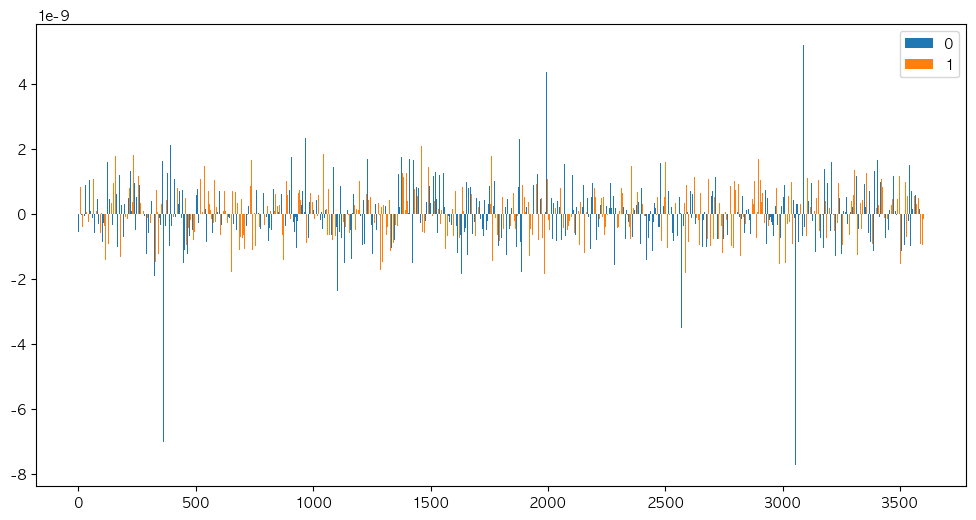

In [31]:
# 가로: 샘플, 세로: 전체 센서 값 평균(plot) - 그룹별(0,1)
plt.figure(figsize=(12,6))
plt.bar(train_0.index, train_0.iloc[:,:-1].mean(axis=1), label='0')
plt.bar(train_1.index, train_1.iloc[:,:-1].mean(axis=1), label='1')
plt.legend()
plt.show()

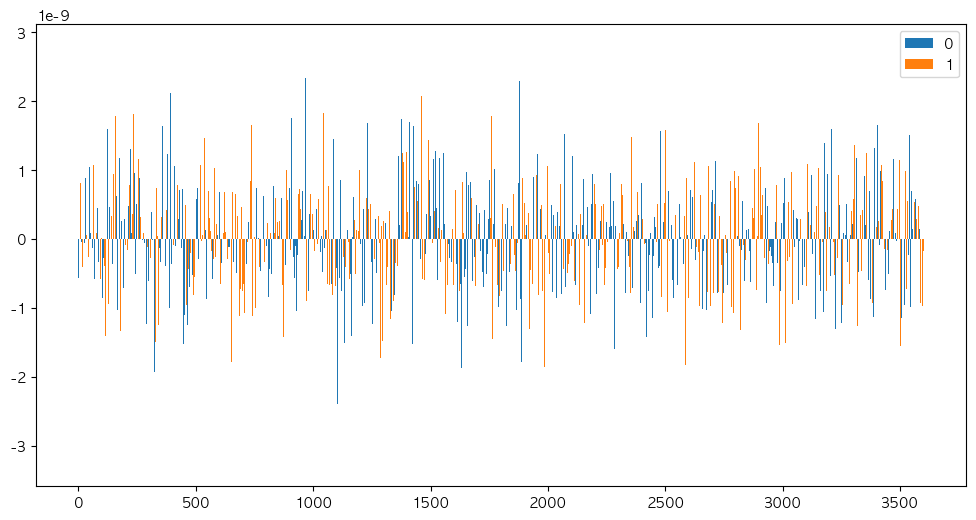

In [32]:
# 센서 평균값이 높은 샘플(인덱스) 추출, 제거
drop_idx = abs(train_0.iloc[:, :-1].mean(axis=1)).sort_values(ascending=False).head(10).index
train_0_drop = train_0.drop(drop_idx)

# 센서 평균값이 높은 인덱스 제거 후 그래프 다시 그리기
plt.figure(figsize=(12,6))
plt.bar(train_0_drop.index, train_0_drop.iloc[:,:-1].mean(axis=1), label='0')
plt.bar(train_1.index, train_1.iloc[:,:-1].mean(axis=1), label='1')
plt.legend()
plt.show()

In [33]:
drop_idx

Int64Index([3054, 1270, 362, 1092, 3088, 1993, 1880, 2568, 1558, 2366], dtype='int64')

In [34]:
train_df_drop = train_df.drop(drop_idx)
train_df_drop

,s1,s2,s3,s4,s5,s6,s7,s8,s9,s10,...,s492,s493,s494,s495,s496,s497,s498,s499,s500,target
0,-0.797172,-0.664392,-0.373015,0.040815,0.526936,0.984288,1.353120,1.578108,1.659251,1.640809,...,0.722417,0.362068,0.092083,-0.081268,-0.212573,-0.391456,-0.664392,-1.073796,-1.564343,0
1,0.804855,0.634629,0.373474,0.038343,-0.340988,-0.740860,-1.109667,-1.395357,-1.570192,-1.619951,...,0.049213,-0.258138,-0.510583,-0.683647,-0.773817,-0.785255,-0.714885,-0.560443,-0.319086,1
2,0.727985,0.111284,-0.499124,-1.068629,-1.578351,-1.990534,-2.302031,-2.503403,-2.585211,-2.550600,...,0.463685,0.507735,0.517174,0.504588,0.476270,0.438513,0.394463,0.339400,0.255391,0
3,-0.234439,-0.502157,-0.732488,-0.946128,-1.139739,-1.323336,-1.490243,-1.607077,-1.620430,-1.506933,...,-0.929437,-0.922761,-0.929437,-0.909409,-0.835970,-0.695768,-0.478790,-0.188707,0.119736,0
4,-0.171328,-0.062285,0.235829,0.710396,1.239969,1.649823,1.876321,1.865535,1.703751,1.466467,...,0.725496,0.697453,0.731967,0.808545,0.839823,0.733046,0.437520,-0.026585,-0.602213,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3596,0.196022,-0.070102,-0.336226,-0.516799,-0.555282,-0.442793,-0.221369,0.025217,0.233320,0.350545,...,1.129082,0.528158,-0.039020,-0.573043,-1.061479,-1.514392,-1.934743,-2.316612,-2.603753,0
3597,0.041994,0.422255,0.740529,0.975426,1.109891,1.137270,1.058349,0.894955,0.671224,0.421544,...,-0.392667,-0.333749,-0.316543,-0.340299,-0.392876,-0.450805,-0.482609,-0.467769,-0.393755,1
3598,-0.570054,-0.333165,-0.293519,-0.425344,-0.590869,-0.615648,-0.348033,0.275412,1.153586,2.035725,...,0.579700,0.157463,-0.353980,-0.885246,-1.314421,-1.512655,-1.393714,-0.942733,-0.270722,0
3599,2.006732,2.079150,2.022036,1.867560,1.648112,1.379446,1.093717,0.784057,0.434150,0.029284,...,1.148971,0.928088,0.634953,0.311682,-0.007376,-0.270543,-0.432145,-0.441231,-0.280709,1


In [35]:
# # Auto ML로 정확도 높은 ML 모델 확인하기
# from autogluon.tabular import TabularPredictor

# # AutoGluon ML로 학습 및 예측, 정확도 출력
# #   -> TabularPredictor.fit() 함수는 자동으로 훈련 데이터를 훈련 데이터와 검증 데이터로 분할(기본: 20%)
# predictor = TabularPredictor(label='target').fit(train_df_drop) 
# y_pred = predictor.predict(test_df)
# accuracy = (test_df.target == y_pred).mean() # 정확도 계산, True는 1, False는 0이므로 mean()값은 예측이 맞은 비율임
# print(f"Best model을 test 데이터셋으로 평가했을 때 정확도 : {accuracy}")

##### - 센서 평균값이 튀는 샘플을 제거 했을 때 ML 정확도는 크게 변화 없음

In [36]:
# x_train_drop = train_df_drop.iloc[:, :-1]
# y_train_drop = train_df_drop.iloc[:, -1]
# x_test = test_df.iloc[:, :-1]
# y_test = test_df.iloc[:, -1]

# print(x_train_drop.shape)
# print(y_train_drop.shape)
# print(x_test.shape)
# print(y_test.shape)

In [37]:
# # ML 모델별로 학습하기
# from catboost import CatBoostClassifier

# model = [xgb.XGBClassifier(),
#         LGBMClassifier(),
#         CatBoostClassifier(verbose=0), #iteration=100:77.6%, 1000:84.55%, 1500:85.0%, 2000:84.62%
#         RandomForestClassifier()]

# # 모델명 리스트 (출력시 모델명 텍스트로 사용)
# model_list = []
# for i in range(len(model)):
#     model_list.append(type(model[i]).__name__)


# # 전체 모델 학습 후 정확도, 혼동행렬, Feat.Import. 출력하기
# for i in range(len(model)):
#     model[i].fit(x_train_drop, y_train_drop)
#     y_pred = model[i].predict(x_test)
#     accuracy = accuracy_score(y_test, y_pred)
#     print(f'{model_list[i]}_acc : {round(accuracy*100,2)}%')


##### - 센서 평균값이 튀는 샘플을 제거 했을 때 ML 정확도는 크게 변화 없음

##### - 센서 평균값이 튀는 샘플을 제거 했을 때 CNN 학습 안됨
#####   -> 5개만 제거 해도 안됨. 튀는 값들이 클래스 판별에 중요한 역할을 하는 것으로 보임

In [38]:
##################################
# 후반부만 학습시켜보기 (s403 ~)
##################################

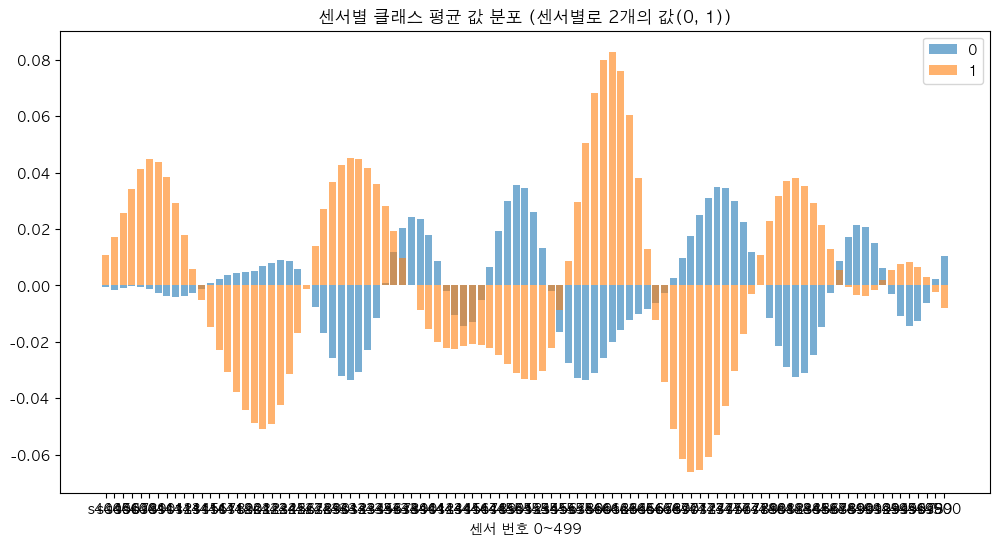

In [39]:
# 가로:센서, 세로:그룹별(0,1) 모든 제품들 센서값의 평균(scatter)
#   -> 센서별 그룹평균 값 분포 (센서별로 2개의 값(0, 1))
plt.figure(figsize=(12,6))
col_i = 403
plt.bar(s_means.columns[col_i:], s_means.iloc[0,col_i:], alpha=0.6, label='0')
plt.bar(s_means.columns[col_i:], s_means.iloc[1,col_i:], alpha=0.6, label='1')
plt.title('센서별 클래스 평균 값 분포 (센서별로 2개의 값(0, 1))')
plt.xlabel('센서 번호 0~499')
plt.legend()

plt.show()

In [40]:
train_403 = train_df.iloc[:,402:]
test_403 = test_df.iloc[:,402:]
test_403

,s403,s404,s405,s406,s407,s408,s409,s410,s411,s412,...,s492,s493,s494,s495,s496,s497,s498,s499,s500,target
0,0.972523,1.501058,1.708779,1.627999,1.362577,1.097155,0.883664,0.793651,0.786727,0.772879,...,0.390903,0.974831,1.258717,1.143316,0.647092,-0.049582,-0.690402,-0.976596,-0.794263,0
1,0.043458,-0.147152,-0.250264,-0.138314,0.192627,0.636500,1.030290,1.226694,1.157952,0.820137,...,-0.346502,-0.924912,-1.208716,-1.247996,-1.139974,-1.041772,-1.041772,-1.159614,-1.375659,0
2,-0.349934,-0.410370,-0.440357,-0.439896,-0.406218,-0.343014,-0.251207,-0.130797,0.014802,0.177378,...,2.276019,1.219548,0.081881,-1.050250,-2.092881,-2.983269,-3.675281,-4.136622,-4.339612,0
3,1.144495,1.567535,1.756104,1.667630,1.327277,0.791865,0.156896,-0.442998,-0.901933,-1.156878,...,-1.124551,-1.302012,-1.340564,-1.271440,-1.146352,-1.011328,-0.931222,-0.934498,-1.001288,1
4,1.103746,1.343477,1.506006,1.538512,1.416615,1.152504,0.811192,0.453627,0.122473,-0.161141,...,0.441438,0.206176,-0.006941,-0.146919,-0.183082,-0.112382,0.008987,0.131413,0.186266,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1315,0.990010,1.736452,2.192954,2.205292,1.761128,0.976438,0.022842,-0.827362,-1.397372,-1.631792,...,0.865397,1.366315,1.896845,2.229968,2.192954,1.761128,0.939424,-0.096588,-1.076587,0
1316,-2.182632,-2.255060,-2.055305,-1.636696,-1.060339,-0.402589,0.277127,0.913033,1.451630,1.842667,...,-1.916656,-1.774917,-1.439674,-0.935756,-0.298758,0.406564,1.100995,1.722323,2.191682,1
1317,0.271086,0.603534,0.941346,1.188731,1.291102,1.224115,1.015647,0.721510,0.398746,0.088710,...,0.272573,-0.040822,-0.235795,-0.304746,-0.270086,-0.192379,-0.126553,-0.117822,-0.189094,1
1318,-0.716805,-0.936250,-1.140510,-1.319080,-1.452797,-1.520913,-1.509296,-1.401396,-1.195180,-0.897333,...,0.176298,-0.031868,-0.262996,-0.492936,-0.698291,-0.870596,-1.000708,-1.084108,-1.109963,1


In [41]:
# # Auto ML로 정확도 높은 ML 모델 확인하기
# from autogluon.tabular import TabularPredictor

# # AutoGluon ML로 학습 및 예측, 정확도 출력
# #   -> TabularPredictor.fit() 함수는 자동으로 훈련 데이터를 훈련 데이터와 검증 데이터로 분할(기본: 20%)
# predictor = TabularPredictor(label='target').fit(train_403) 
# y_pred = predictor.predict(test_403)
# accuracy = (test_403.target == y_pred).mean() # 정확도 계산, True는 1, False는 0이므로 mean()값은 예측이 맞은 비율임
# print(f"Best model을 test 데이터셋으로 평가했을 때 정확도 : {accuracy}")

##### - s403 이후만 가지고 학습할 경우, 오히려 데이터 부족으로 학습이 잘 안됨

In [42]:
# x_train_403 = train_403.iloc[:, :-1]
# y_train_403 = train_403.iloc[:, -1]
# x_test_403 = test_403.iloc[:, :-1]
# y_test_403 = test_403.iloc[:, -1]

# print(x_train_403.shape)
# print(y_train_403.shape)
# print(x_test_403.shape)
# print(y_test_403.shape)

In [43]:
# # ML 모델별로 학습하기
# from catboost import CatBoostClassifier

# model = [xgb.XGBClassifier(),
#         LGBMClassifier(),
#         CatBoostClassifier(verbose=0), #iteration=100:77.6%, 1000:84.55%, 1500:85.0%, 2000:84.62%
#         RandomForestClassifier()]

# # 모델명 리스트 (출력시 모델명 텍스트로 사용)
# model_list = []
# for i in range(len(model)):
#     model_list.append(type(model[i]).__name__)


# # 전체 모델 학습 후 정확도, 혼동행렬, Feat.Import. 출력하기
# for i in range(len(model)):
#     model[i].fit(x_train_403, y_train_403)
#     y_pred = model[i].predict(x_test_403)
#     accuracy = accuracy_score(y_test_403, y_pred)
#     print(f'{model_list[i]}_acc : {round(accuracy*100,2)}%')


##### - s403 이후만 가지고 학습할 경우, ML, CNN 모두 학습 잘 안됨
#####   -> 오히려 데이터 부족으로 학습이 잘 안되는 듯

In [44]:
##################################
# target과 상관계수 상위 센서로만 학습시켜보기 (490 -> 470 -> 450 -> 400 -> 300)
##################################
# 정렬 시키면 안됨. 센서 순서가 흐트러짐
# 낮은 인덱스를 찾아서 드롭 시키기

In [45]:
train_corr = abs(train_df.corr())
corr_target = train_corr.target.sort_values(ascending=False).tail(50)
corr_target.index
train_corr = train_df.drop(corr_target.index, axis=1)
test_corr = test_df.drop(corr_target.index, axis=1)
train_corr

,s3,s4,s5,s6,s7,s9,s10,s11,s12,s13,...,s490,s491,s492,s494,s495,s496,s497,s498,s500,target
0,-0.373015,0.040815,0.526936,0.984288,1.353120,1.659251,1.640809,1.552290,1.437952,1.279354,...,1.489588,1.120756,0.722417,0.092083,-0.081268,-0.212573,-0.391456,-0.664392,-1.564343,0
1,0.373474,0.038343,-0.340988,-0.740860,-1.109667,-1.570192,-1.619951,-1.545709,-1.367893,-1.119998,...,0.727256,0.386403,0.049213,-0.510583,-0.683647,-0.773817,-0.785255,-0.714885,-0.319086,1
2,-0.499124,-1.068629,-1.578351,-1.990534,-2.302031,-2.585211,-2.550600,-2.409010,-2.179321,-1.883556,...,0.332164,0.394463,0.463685,0.517174,0.504588,0.476270,0.438513,0.394463,0.255391,0
3,-0.732488,-0.946128,-1.139739,-1.323336,-1.490243,-1.620430,-1.506933,-1.246560,-0.852660,-0.358617,...,-0.962819,-0.952804,-0.929437,-0.929437,-0.909409,-0.835970,-0.695768,-0.478790,0.119736,0
4,0.235829,0.710396,1.239969,1.649823,1.876321,1.703751,1.466467,1.250755,1.056614,0.888359,...,0.798838,0.776188,0.725496,0.731967,0.808545,0.839823,0.733046,0.437520,-0.602213,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3596,-0.336226,-0.516799,-0.555282,-0.442793,-0.221369,0.233320,0.350545,0.350545,0.267067,0.144218,...,2.230283,1.715205,1.129082,-0.039020,-0.573043,-1.061479,-1.514392,-1.934743,-2.603753,0
3597,0.740529,0.975426,1.109891,1.137270,1.058349,0.671224,0.421544,0.185007,-0.016268,-0.176881,...,-0.520128,-0.463329,-0.392667,-0.316543,-0.340299,-0.392876,-0.450805,-0.482609,-0.393755,1
3598,-0.293519,-0.425344,-0.590869,-0.615648,-0.348033,1.153586,2.035725,2.590779,2.600691,2.015902,...,1.123851,0.902821,0.579700,-0.353980,-0.885246,-1.314421,-1.512655,-1.393714,-0.270722,0
3599,2.022036,1.867560,1.648112,1.379446,1.093717,0.434150,0.029284,-0.418453,-0.886437,-1.326950,...,1.268331,1.268671,1.148971,0.634953,0.311682,-0.007376,-0.270543,-0.432145,-0.280709,1


In [46]:
print(train_corr.shape)
print(test_corr.shape)

(3601, 451)
(1320, 451)


In [47]:
# # Auto ML로 정확도 높은 ML 모델 확인하기
# from autogluon.tabular import TabularPredictor

# # AutoGluon ML로 학습 및 예측, 정확도 출력
# #   -> TabularPredictor.fit() 함수는 자동으로 훈련 데이터를 훈련 데이터와 검증 데이터로 분할(기본: 20%)
# predictor = TabularPredictor(label='target').fit(train_corr) 
# y_pred = predictor.predict(test_corr)
# accuracy = (test_corr.target == y_pred).mean() # 정확도 계산, True는 1, False는 0이므로 mean()값은 예측이 맞은 비율임
# print(f"Best model을 test 데이터셋으로 평가했을 때 정확도 : {accuracy}")

In [48]:
x_train = train_corr.iloc[:, :-1]
y_train = train_corr.iloc[:, -1]
x_test = test_corr.iloc[:, :-1]
y_test = test_corr.iloc[:, -1]

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(3601, 450)
(3601,)
(1320, 450)
(1320,)


In [49]:
# # ML 모델별로 학습하기
# from catboost import CatBoostClassifier

# model = [xgb.XGBClassifier(),
#         LGBMClassifier(),
#         CatBoostClassifier(verbose=0), #iteration=100:77.6%, 1000:84.55%, 1500:85.0%, 2000:84.62%
#         RandomForestClassifier()]

# # 모델명 리스트 (출력시 모델명 텍스트로 사용)
# model_list = []
# for i in range(len(model)):
#     model_list.append(type(model[i]).__name__)


# # 전체 모델 학습 후 정확도, 혼동행렬, Feat.Import. 출력하기
# for i in range(len(model)):
#     model[i].fit(x_train, y_train)
#     y_pred = model[i].predict(x_test)
#     accuracy = accuracy_score(y_test, y_pred)
#     print(f'{model_list[i]}_acc : {round(accuracy*100,2)}%')


In [50]:
### 센서 평균값 중 튀는값 구할때, 전체 원데이터를 평균내는게 맞나. (+,- 상쇄)
### -> abs로 평균 ?

### 센서별 클래스값 borplot으로...
### 점백이 그래프 수정... sns 그래프 다른거 없나... 날개모양?

### 1. 머신러닝 학습 결과 (AutoML, 대표 4개)
### 2. 딥러닝 학습 결과 (CNN, RNN)
### 3. 데이터 전처리 다시
##### .....0) 튀는 데이터 제거
##### .....1) s430 이후만 학습 (어디서 부터 자를지)
##### .....2) 상관계수 상위 300개?만 학습
##### .....3) CatBoost의 Feature importances 상위 300개?만 학습 -> 생략
### 4. 머신러닝 재학습 (AutoML, 대표 4개)
[원본 트레인셋]
Best model을 test 데이터셋으로 평가했을 때 정확도 : 0.8469696969696969
XGBClassifier_acc : 77.05%
LGBMClassifier_acc : 78.56%
CatBoostClassifier_acc : 84.55%
RandomForestClassifier_acc : 76.06%

[0클래스 튀는 값 상위 20개 제거 후] -> 비슷, 좋아지지는 않음
Best model을 test 데이터셋으로 평가했을 때 정확도 : 0.818939393939394
XGBClassifier_acc : 78.33%
LGBMClassifier_acc : 79.02%
CatBoostClassifier_acc : 84.62%
RandomForestClassifier_acc : 73.56%

[상위 10개 제거 후] -> 비슷, 좋아지지는 않음
Best model을 test 데이터셋으로 평가했을 때 정확도 : 0.8325757575757575
XGBClassifier_acc : 77.27%
LGBMClassifier_acc : 79.47%
CatBoostClassifier_acc : 83.79%
RandomForestClassifier_acc : 74.02%

[s403 이후만 학습] -> 과소적합 (데이터 부족때문인듯)
Best model을 test 데이터셋으로 평가했을 때 정확도 : 0.825
XGBClassifier_acc : 73.79%
LGBMClassifier_acc : 72.27%
CatBoostClassifier_acc : 74.24%
RandomForestClassifier_acc : 71.14%

[corr_490] -> 약간 떨어짐
Best model을 test 데이터셋으로 평가했을 때 정확도 : 0.8393939393939394
XGBClassifier_acc : 77.05%
LGBMClassifier_acc : 78.11%
CatBoostClassifier_acc : 83.48%
RandomForestClassifier_acc : 74.24%

[corr_470] -> 비슷하거나 약간 낮음. 베스트모델은 약간 더 좋아짐
Best model을 test 데이터셋으로 평가했을 때 정확도 : 0.8575757575757575
XGBClassifier_acc : 76.82%
LGBMClassifier_acc : 78.48%
CatBoostClassifier_acc : 83.41%
RandomForestClassifier_acc : 74.09%

[corr_450] -> 약간 떨어짐
Best model을 test 데이터셋으로 평가했을 때 정확도 : 0.8462121212121212
XGBClassifier_acc : 75.76%
LGBMClassifier_acc : 78.11%
CatBoostClassifier_acc : 83.86%
RandomForestClassifier_acc : 73.03%


### 5. 딥러닝 재학습 (CNN)
[원본 트레인셋]
Max train acc : 388_epoch_0.9864583611488342
Max val acc: 388_epoch_0.9791955351829529 
test acrr  0.9712121486663818
test loss  0.09361912310123444 


[0 클래스 튀는 샘플 행 상위 30~100개 제거 후] - 제거 전과 비슷함
- 0클래스가 91개 많아서 100개 제거해도 균형은 맞음

[튀는 샘플 행 상위 20개 제거 후] - 제거 전과 비슷함
Max train acc : 352_epoch_0.98591548204422
Max val acc: 352_epoch_0.9774965047836304 
test acrr  0.9628787636756897
test loss  0.10508657246828079

[상위 10개 제거 후] -> 제거 전과 비슷하나 val acc는 최고기록임. 개선 가능성 있음 (batch size)
Max train acc : 399_epoch_0.9851694703102112
Max val acc: 399_epoch_0.9816642999649048 
test acrr  0.9689394235610962
test loss  0.10294175893068314 

[상위 5개 제거 후] - 제거 전과 비슷함
Max train acc : 324_epoch_0.9885257482528687
Max val acc: 324_epoch_0.980555534362793 
test acrr  0.9643939137458801
test loss  0.09963967651128769 

[s403 열 이후만 학습] -> 학습 잘 안되고 과적합 
test acrr  0.8984848260879517
test loss  0.2471424639225006 

--- 정렬하는 동안 모양이 흐트러짐 : 정렬하지 않고 다시 ---

[corr_490] -> 약간 떨어짐..(중간중간 이빠져서?) 과적합은 없음
Max train acc : 384_epoch_0.9750000238418579
Max val acc: 384_epoch_0.9653259515762329 
test acrr  0.9515151381492615
test loss  0.129542276263237 

[corr_470] -> 학습 안됨 
Max train acc : 331_epoch_0.9284722208976746
Max val acc: 331_epoch_0.919556200504303 
test acrr  0.9037878513336182
test loss  0.23713327944278717 

[corr_495] -> 후반부 과적합
Max train acc : 394_epoch_0.9854166507720947
Max val acc: 394_epoch_0.9750346541404724 
test acrr  0.9621211886405945
test loss  0.11294251680374146 

### 6. 베스트모델 파이토치로 재구현
## ** 뒷단에서 기술 쓰는거보단 앞단에서 데이터를 잘 분석하고, 가공하는 과정이 중요하다.

In [51]:
# # CNN 반복학습 시키기

# # 데이터 shape 변환 (for CNN, RNN)

# # ============================ [x_train 변경] =====================
# x_train_exp = np.expand_dims(x_train, -1) # x_train 배열의 마지막 차원에 새로운 축을 추가
# x_test_exp = np.expand_dims(x_test, -1) # x_train 배열의 마지막 차원에 새로운 축을 추가

# # 모델 정의(구조)

# filter = 64
# batch = 64
# act = 'LeakyReLU'
# pool = 2
# kernel = 3
# def make_cnn_model():
#     model = Sequential()
#     model.add(Conv1D(filters=filter, kernel_size=kernel, activation=act, padding='same',
#                      input_shape=(495, 1)))
#     model.add(BatchNormalization())
#     # model.add(Dropout(0.1))
#     # model.add(MaxPooling1D(pool_size=pool))

#     model.add(Conv1D(filters=filter, kernel_size=kernel, activation=act, padding='same'))
#     model.add(BatchNormalization())
#     # model.add(MaxPooling1D(pool_size=pool))

#     model.add(Conv1D(filters=filter, kernel_size=kernel, activation=act, padding='same'))
#     model.add(BatchNormalization())
#     # model.add(MaxPooling1D(pool_size=pool))

#     model.add(GlobalAveragePooling1D())
#     # model.add(Flatten())
#     # model.add(Dense(8, activation='swish'))
#     model.add(Dense(2, activation='softmax'))
#     return model
# #=========================================================
# cnn_model = make_cnn_model() # 모델 초기화
# # cnn_model = load_model('best_model.h5')
# #=========================================================
# epochs = 400
# #=========================================================
# cnn_model.compile(optimizer='adam',
#                   loss='sparse_categorical_crossentropy',
#                   metrics=['sparse_categorical_accuracy'])

# callbacks = [
#     ModelCheckpoint('best_model.h5', save_best_only=True,
#                     monitor='val_sparse_categorical_accuracy', mode='max',
#                     # monitor='val_loss', mode='min',
#                     ),
#     # ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=20, min_lr=0.0001)
#     ]

# history = cnn_model.fit(x_train_exp, y_train,
#                         batch_size=batch,
#                         validation_split=0.2,
#                         epochs=epochs, callbacks=callbacks)


# # # 학습 중 정확도 베스트 정확도
# max_train_accuracy = max(history.history['sparse_categorical_accuracy'])
# max_val_accuracy = max(history.history['val_sparse_categorical_accuracy'])
# max_tra_acc_idx = np.argmax(history.history['sparse_categorical_accuracy']) + 1
# max_val_acc_idx = np.argmax(history.history['val_sparse_categorical_accuracy']) + 1

# # 학습 중 손실 베스트
# min_train_loss = min(history.history['loss'])
# min_val_loss = min(history.history['val_loss'])
# min_tra_loss_idx = np.argmin(history.history['loss']) + 1
# min_val_loss_idx = np.argmin(history.history['val_loss']) + 1

# print(f'Max train acc : {max_tra_acc_idx}_epoch_{max_train_accuracy}')
# print(f'Max val acc: {max_tra_acc_idx}_epoch_{max_val_accuracy}', '\n')
# print(f'Min train loss : {min_tra_loss_idx}_epoch_{min_train_loss}')
# print(f'Min val loss: {min_val_loss_idx}_epoch_{min_val_loss}', '\n')

# #  정확도 베스트 모델로 평가 (베스트 모델은 callbacks에 설정 됨)
# model = load_model('best_model.h5')
# scores = model.evaluate(x_test_exp, y_test)
# print('test acrr ', scores[1])
# print('test loss ', scores[0], '\n')

# # Plotting the accuracy and validation accuracy
# plt.figure(figsize=(12, 12))
# plt.plot(history.history['sparse_categorical_accuracy'], label='Training accuracy')
# plt.plot(history.history['val_sparse_categorical_accuracy'], label='Validation accuracy')
# plt.plot(history.history['loss'], label='loss')
# plt.plot(history.history['val_loss'], label='val_loss')
# plt.ylabel('Accuracy')
# plt.xlabel('Epoch')
# plt.legend(loc='right')
# plt.show()

# # 모델 구조 / 파라미터 개수 확인
# model.summary()


In [ ]:
################ r2